In [48]:
import pandas as pd
import numpy as np 
import random
import os 
import sys 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib 
import json
import matplotlib.pyplot as plt

In [49]:
# Get the current working directory
current_working_directory = os.getcwd()

# Construct the path to the 1D_radiomics/utils directory
utils_path = os.path.abspath(os.path.join(current_working_directory, '..', '1D_radiomics', 'utils'))

# Add the path to sys.path
sys.path.append(utils_path)

# Now you can import your module
import src.feature_selection as fsa 
import src.dataset as dataset
import src.test as test
import src.train as train
from src import analysis_functions

# Test ICM models

In [50]:
np.random.seed(42)
random.seed(42)
print("Seed example = ", random.randint(0, 100))

Seed example =  81


# One year local recurrence

## Load data

### ICM config

In [51]:

params = dataset.load_config('/home/tachennf/Documents/delta-rad/1D_radiomics/full_training_settings.yaml')

icm_folder_path = '/home/tachennf/Documents/delta-rad/data/ICM_0.35T/extracted_radiomics/'
icm_outcome_csv = icm_folder_path + 'one_year_local_control_status.csv'
icm_results_file = '/home/tachennf/Documents/delta-rad/1D_radiomics/0.35T/json_results/full_training_mridian.json'
models_folder = '/home/tachennf/Documents/delta-rad/1D_radiomics/0.35T/models/one_year_local_control_status/'



###  Madrid config

In [52]:
madrid_folder_path = '/home/tachennf/Documents/delta-rad/data/Madrid/combat_csv/'
madrid_outcome_csv = madrid_folder_path + 'one_year_local_control_status.csv'
madrid_results_file = '/home/tachennf/Documents/delta-rad/madrid_study/json_results/full_training_madrid_mridian.json'

###  Common config

In [53]:
delta_rad_tables = params['paths']['delta_rad_tables']
outcomes_list = ['one_year_local_control_status']
feat_sel_algo_list = ['ANOVA_K_BEST', 'RF']
pred_algo_list = params['parameters']['pred_algo_list']
max_features = params['parameters']['max_features']
smote = params['parameters']['smote']

### Madrid functions

In [54]:
def load_selected_features(results_file: str, table: str, fs_algo: str, pred_algo: str, outcome: str, nb_features: int): 
    """
    Load the selected features from the results file.

    Parameters
    ----------
    results_file : str
        Path to the results file.
    table : str
        Name of the table.
    fs_algo : str
        Feature selection algorithm.
    pred_algo : str 
        Prediction algorithm.
    outcome : str
        Outcome variable.
    nb_features : int
        Number of features to select.

        Returns
        -------
        list
            List of selected features.
    """
    results = json.load(open(results_file))
    return results[table][fs_algo][pred_algo][outcome][str(nb_features)]['features']


In [55]:
def get_xy(rad_csv_path: str, outcome_csv_path: str):
    """
    Load and preprocess dataset for training and validation.

    Parameters:
    rad_csv_path (str): Path to the radiomics CSV file.
    outcome_csv_path (str): Path to the outcome CSV file.
    
    Returns:
    tuple: A tuple containing:
        - X (pd.DataFrame): Features.
        - y (pd.DataFrame): Labels.
        - features_list (pd.Index): List of feature names.
    """

    X = pd.read_csv(rad_csv_path, index_col=0)
    X = X.dropna() # delete nan values

    y = pd.read_csv(outcome_csv_path, index_col=0)
    y = y.dropna() # delete nan values

    return X, y, X.columns

## Test models

In [56]:
results = test.def_results_dict(delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcomes_list, max_features)
for table in delta_rad_tables:
    print('Testing model on table ', table)
    for outcome in outcomes_list: 
        X_icm, y_icm, icm_features_list = dataset.get_xy(os.path.join(icm_folder_path, table), os.path.join(icm_folder_path, icm_outcome_csv), outcome, smote=smote) # Load the dataset 
        X_madrid, y_madrid, madrid_features_list = get_xy(os.path.join(madrid_folder_path, table), os.path.join(madrid_folder_path, madrid_outcome_csv)) # Load the dataset
        for fs_algo in feat_sel_algo_list:
            if 'CHI2' in fs_algo:
                min_max_scaler = MinMaxScaler()
                X_icm = min_max_scaler.fit_transform(X_icm)
                X_madrid = min_max_scaler.fit_transform(X_madrid)
            else:     
                znorm_scaler = StandardScaler()
                X_icm = znorm_scaler.fit_transform(X_icm)
                X_madrid = znorm_scaler.fit_transform(X_madrid)
            
            for nb_features in range(1, max_features+1): # number of features selected
                best_features = load_selected_features(icm_results_file, table, fs_algo, 'RF', outcome, nb_features) # get previously selected features
                sel_features_icm, X_filtered_icm = fsa.filter_dataset3(X_icm, best_features, nb_features, icm_features_list) # filter dataset based on selected features
                sel_features_madrid, X_filtered_madrid = fsa.filter_dataset3(X_madrid, best_features, nb_features, madrid_features_list)
                for pred_algo in pred_algo_list:
                    model_path = models_folder + table + "_" + fs_algo + "_" + pred_algo + "_" + str(nb_features) + ".joblib"
                    loaded_model = joblib.load(model_path)
                    y_icm = np.array(y_icm).reshape(-1, 1).ravel() # convert to numpy array to avoid errors
                    y_madrid = np.array(y_madrid).reshape(-1, 1).ravel() # convert to numpy array
                    optimal_threshold, train_auc, train_brier_loss = train.compute_opt_threshold(loaded_model, X_filtered_icm, y_icm) # compute optimal threshold based on train set results
                    brier_loss, brier_loss_ci, test_auc, test_auc_ci, sensitivity, sensitivity_ci, specificity, specificity_ci = test.compute_test_metrics(loaded_model, X_filtered_madrid, y_madrid, optimal_threshold) # compute test metrics on Madrid data 
                    results = test.save_results(results, table, fs_algo, pred_algo, outcome, sel_features_madrid, train_auc, train_brier_loss, test_auc, sensitivity, specificity, brier_loss, test_auc_ci, sensitivity_ci, specificity_ci, brier_loss_ci) # save metrics
                    results[table][fs_algo][pred_algo][outcome][nb_features]['features'] = sel_features_madrid


results_ser = dataset.convert_to_list(results)
with open(madrid_results_file, 'w') as f: 
    json.dump(results_ser, f)                     
print("Results saved in {} file.".format(madrid_results_file))    

Testing model on table  simu_gtv.csv


Testing model on table  f1_gtv.csv
Testing model on table  f3_gtv.csv
Testing model on table  f5_gtv.csv
Testing model on table  simu_f1_gtv.csv
Testing model on table  simu_f3_gtv.csv
Testing model on table  simu_f5_gtv.csv
Testing model on table  f1_f3_gtv.csv
Testing model on table  f1_f5_gtv.csv
Results saved in /home/tachennf/Documents/delta-rad/madrid_study/json_results/full_training_madrid_mridian.json file.


## Analyze results

In [57]:
nice_tables = ['SIMU', 'F1', 'F3', 'F5', 'Simu_F1', 'Simu_F3', 'Simu_F5', 'F1_F3', 'F1_F5']
results = pd.read_json(madrid_results_file)
results_dict = json.load(open(madrid_results_file))
print(results_dict.keys())  
print(pred_algo_list)
print(feat_sel_algo_list)

dict_keys(['simu_gtv.csv', 'f1_gtv.csv', 'f3_gtv.csv', 'f5_gtv.csv', 'simu_f1_gtv.csv', 'simu_f3_gtv.csv', 'simu_f5_gtv.csv', 'f1_f3_gtv.csv', 'f1_f5_gtv.csv'])
['RF', 'ADABOOST', 'LOGREGRIDGE', 'PSVM', 'KNN', 'BAGG', 'QDA']
['ANOVA_K_BEST', 'RF']


### Compare one algo with different metrics and CI

In [59]:
pred_algo = "BAGG"
feat_sel_algo = "RF"
outcome = "one_year_local_control_status"
inter_res = results['f1_gtv.csv'][feat_sel_algo][pred_algo][outcome]
#for table in delta_rad_tables: 
for nb_features in inter_res.keys():
    print(nb_features, inter_res[nb_features]['features'])
    print("Train AUC: ", np.mean(inter_res[nb_features]['train_metrics']['auc']['values']))
    print("Test AUC: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['auc']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['auc']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['auc']['conf_int']), axis=0)[1]))
    print("Test Brier loss: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['brier_loss']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['brier_loss']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['brier_loss']['conf_int']), axis=0)[1]))
    print("Test sensitivity: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['sensitivity']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['sensitivity']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['sensitivity']['conf_int']), axis=0)[1]))
    print("Test specificity: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['specificity']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['specificity']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['specificity']['conf_int']), axis=0)[1]))
    print('')


1 ['original_shape_Maximum2DDiameterRow']
Train AUC:  0.9994797086368361
Test AUC: 0.475921364152309 (0.178839285714285; 0.784119318181818)
Test Brier loss: 0.40783165200533805 (0.250005310643977; 0.562485477777777)
Test sensitivity: 0.5999999999999991 (0.6000000000000001; 0.6000000000000001)
Test specificity: 0.53125 (0.53125; 0.53125)

2 ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity']
Train AUC:  0.9999999999999991
Test AUC: 0.39445221993446306 (0.08810924369747901; 0.686190476190476)
Test Brier loss: 0.340666684151607 (0.23193134815288602; 0.457419862466016)
Test sensitivity: 0.2 (0.2; 0.2)
Test specificity: 0.625 (0.625; 0.625)

3 ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity', 'original_firstorder_Kurtosis']
Train AUC:  1.0
Test AUC: 0.7259795980979731 (0.391176470588235; 0.942941628264208)
Test Brier loss: 0.14096814414414402 (0.084636996996997; 0.21360504504504502)
Test sensitivity: 0.2 (0.2; 0.2)
Test specificity

### Best train AUC
#### Display

In [12]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='train_auc', k = 10)
analysis_functions.print_top_results(top_results, metric='train_auc')

Table: simu_gtv.csv
  Mean train_auc: 1.0, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_Sphericity', 'original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity'], Parameters: {}
  Mean train_auc: 0.996, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: ADABOOST, Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_Flatness'], Parameters: {}
  Mean train_auc: 0.986, Feature Selection Algorithm: RF, Prediction Algorithm: ADABOOST, Features: ['original_shape_Sphericity', 'original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity'], Parameters: {}

Table: f1_gtv.csv
  Mean train_auc: 1.0, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity', 'original_firstorder_Kurtosis'], Parameters: {}
  Mean train_auc: 0.999, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['o

#### Boxplot

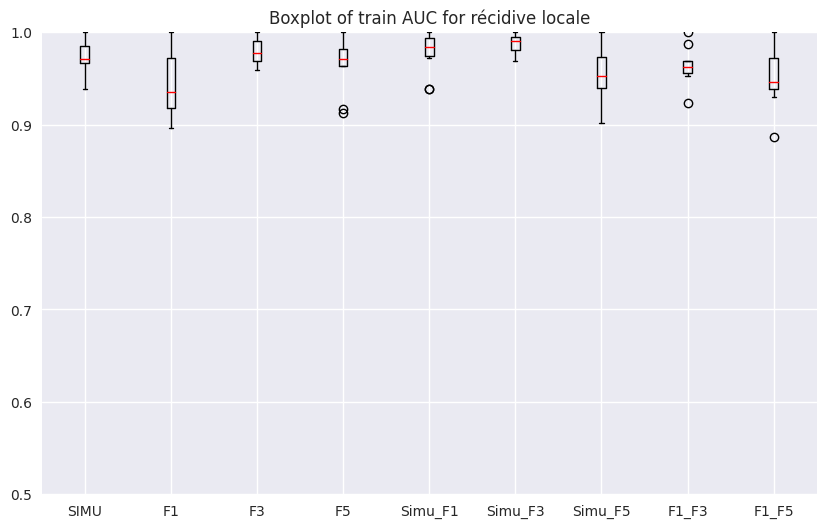

In [13]:
plt.style.use('seaborn-v0_8')
widths = 0.1
medianprops = dict(linestyle='-', linewidth=1, color='red')
data = analysis_functions.get_top_results_to_plot(top_results)
plt.figure(figsize=(10, 6))
_ = plt.boxplot(data.values(), widths=widths, medianprops=medianprops)
plt.title(f'Boxplot of train AUC for récidive locale')
plt.ylim([0.5, 1])
_ = plt.xticks(range(1, len(delta_rad_tables) + 1), nice_tables)


#### Scatter plot

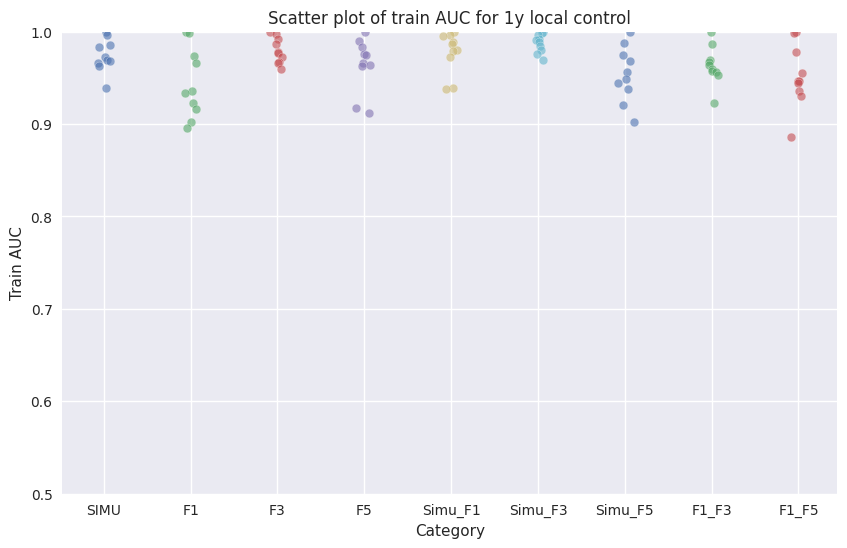

In [14]:
plt.figure(figsize=(10, 6))

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of train AUC for 1y local control')
plt.ylim([0.5, 1])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Train AUC')
plt.show()


### Best train Brier loss
#### Display

In [15]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='train_brier_loss', k = 10)
analysis_functions.print_top_results(top_results, metric='train_brier_loss')

Table: simu_gtv.csv
  Mean train_brier_loss: 0.016, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_Sphericity', 'original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity'], Parameters: {}
  Mean train_brier_loss: 0.023, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_Flatness', 'original_shape_Sphericity'], Parameters: {}
  Mean train_brier_loss: 0.024, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_Sphericity', 'original_shape_Maximum2DDiameterRow'], Parameters: {}

Table: f1_gtv.csv
  Mean train_brier_loss: 0.022, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity', 'original_firstorder_Kurtosis'], Parameters: {}
  Mean train_brier_loss: 0.03, Feature Selection Algorithm: RF, Prediction Algorithm: B

#### Boxplot

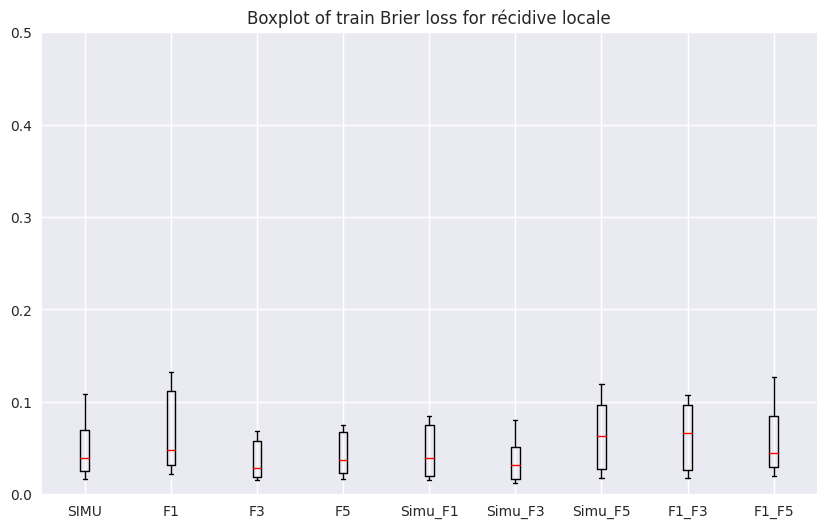

In [16]:
data = analysis_functions.get_top_results_to_plot(top_results)
plt.figure(figsize=(10, 6))
_ = plt.boxplot(data.values(), widths=widths, medianprops=medianprops)
plt.title(f'Boxplot of train Brier loss for récidive locale')
plt.ylim([0, 0.5])
_ = plt.xticks(range(1, len(delta_rad_tables) + 1), nice_tables)

#### Scatter plot

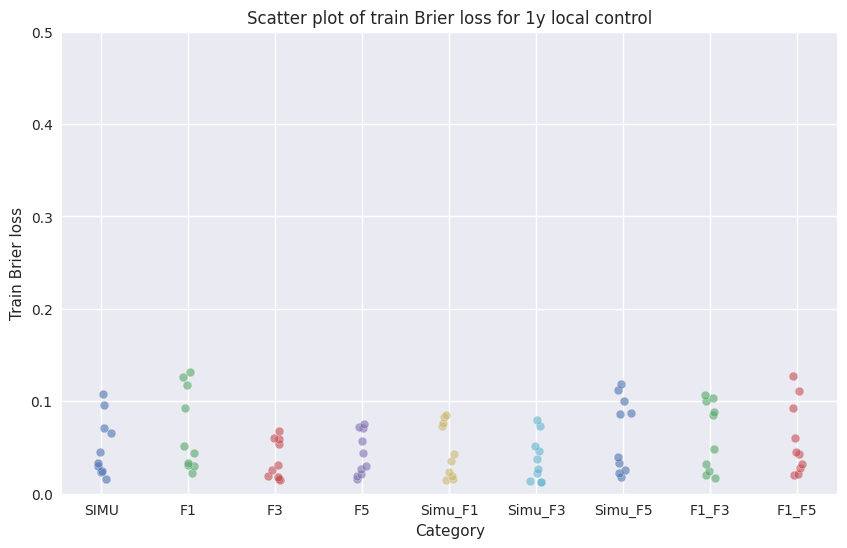

In [17]:
plt.figure(figsize=(10, 6))

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of train Brier loss for 1y local control')
plt.ylim([0, 0.5])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Train Brier loss')
plt.show()


### Best test AUC
#### Display

In [18]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='test_auc', k = 10)
analysis_functions.print_top_results(top_results, metric='test_auc')

Table: simu_gtv.csv
  Mean test_auc: 0.798, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: PSVM, Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_Flatness'], Parameters: {}
  Mean test_auc: 0.745, Feature Selection Algorithm: RF, Prediction Algorithm: PSVM, Features: ['original_shape_Sphericity', 'original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean test_auc: 0.718, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}

Table: f1_gtv.csv
  Mean test_auc: 0.761, Feature Selection Algorithm: RF, Prediction Algorithm: PSVM, Features: ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity'], Parameters: {}
  Mean test_auc: 0.726, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity', 'original_firstorder_Kurtosis'], Parameters: {}
  Mean test_auc:

#### Boxplot

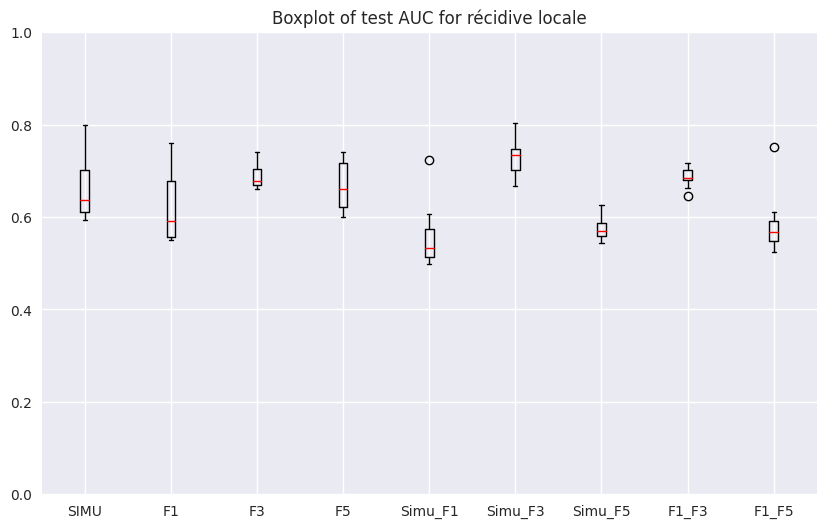

In [19]:
data = analysis_functions.get_top_results_to_plot(top_results)
plt.figure(figsize=(10, 6))
_ = plt.boxplot(data.values(), widths=widths, medianprops=medianprops)
plt.title(f'Boxplot of test AUC for récidive locale')
plt.ylim([0, 1])
_ = plt.xticks(range(1, len(delta_rad_tables) + 1), nice_tables)

#### Scatter plot

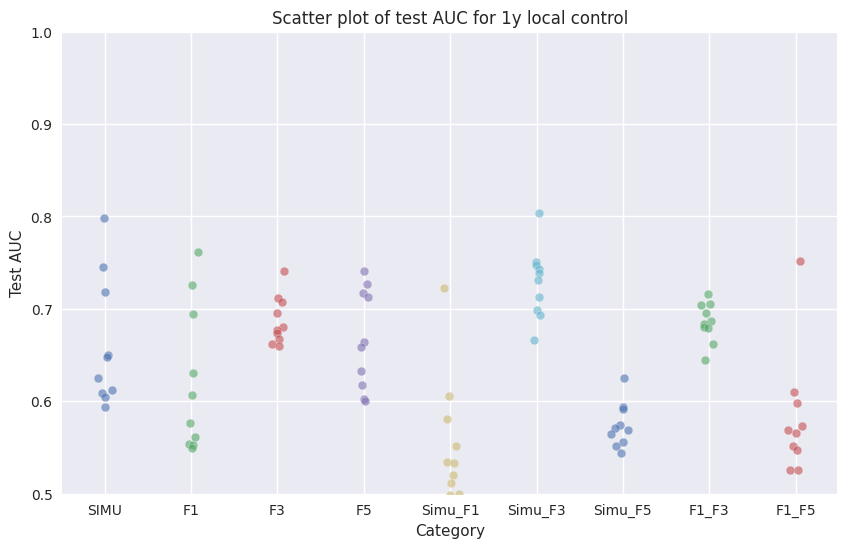

In [20]:
plt.figure(figsize=(10, 6))

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of test AUC for 1y local control')
plt.ylim([0.5, 1])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Test AUC')
plt.show()


### Best test brier loss
#### Display

In [32]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='test_brier_loss', k = 3)
analysis_functions.print_top_results(top_results, metric='test_brier_loss', k = 3)

Table: simu_gtv.csv
  Mean test_brier_loss: 0.217, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: PSVM, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean test_brier_loss: 0.218, Feature Selection Algorithm: RF, Prediction Algorithm: ADABOOST, Features: ['original_shape_Sphericity', 'original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean test_brier_loss: 0.226, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_Flatness', 'original_shape_Sphericity'], Parameters: {}

Table: f1_gtv.csv
  Mean test_brier_loss: 0.141, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity', 'original_firstorder_Kurtosis'], Parameters: {}
  Mean test_brier_loss: 0.199, Feature Selection Algorithm: RF, Prediction Algorithm: RF, Features: ['original_shape_Maximum2DDiameterRow', 'origin

#### Scatter plot

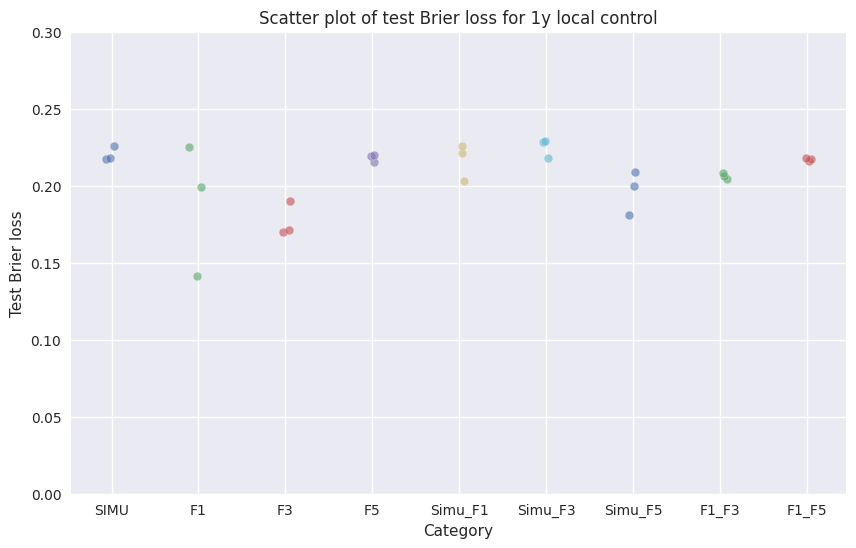

In [33]:
plt.figure(figsize=(10, 6))
data = analysis_functions.get_top_results_to_plot(top_results)

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of test Brier loss for 1y local control')
plt.ylim([0, 0.3])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Test Brier loss')
plt.show()


### Best spe & sens

In [30]:
analysis_functions.find_perf_alg(results, delta_rad_tables, [outcome], feat_sel_algo_list, pred_algo_list, metric='sens_spec', threshold=0.65)

Table: f5_gtv.csv, Outcome: one_year_local_control_status, Feature Selection Algorithm: RF, Prediction Algorithm: RF, Number of Features: 3, '
'                                           TEST AUC: 0.7408558985005651, Sensitivity: 0.8, Specificity: 0.6875, '
'                                           Features: ['original_shape_Sphericity', 'original_glcm_Imc1', 'original_glrlm_GrayLevelNonUniformity']
Table: simu_f3_gtv.csv, Outcome: one_year_local_control_status, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: KNN, Number of Features: 3, '
'                                           TEST AUC: 0.713337902993463, Sensitivity: 0.8, Specificity: 0.65625, '
'                                           Features: ['original_glcm_Idn', 'original_gldm_DependenceNonUniformity', 'original_shape_Maximum2DDiameterSlice']


# Metastatic recurrence
## Load data

### Config ICM

In [34]:

params = dataset.load_config('/home/tachennf/Documents/delta-rad/1D_radiomics/full_training_settings.yaml')

icm_folder_path = '/home/tachennf/Documents/delta-rad/data/ICM_0.35T/extracted_radiomics/'
icm_outcome_csv = icm_folder_path + 'nine_months_metastatic_status.csv'
icm_results_file = '/home/tachennf/Documents/delta-rad/1D_radiomics/0.35T/json_results/full_training_mridian2.json'
models_folder = '/home/tachennf/Documents/delta-rad/1D_radiomics/0.35T/models/nine_months_metastatic_status/'

### Config Madrid

In [35]:
madrid_folder_path = '/home/tachennf/Documents/delta-rad/data/Madrid/combat_csv/'
madrid_outcome_csv = madrid_folder_path + 'nine_months_metastatic_status.csv'
madrid_results_file = '/home/tachennf/Documents/delta-rad/madrid_study/json_results/full_training_madrid_mridian2.json'

### Common config 

In [36]:
delta_rad_tables = params['paths']['delta_rad_tables']
outcomes_list = ['nine_months_metastatic_status']
feat_sel_algo_list = ['ANOVA_K_BEST', 'RF']
pred_algo_list = params['parameters']['pred_algo_list']
max_features = params['parameters']['max_features']
smote = params['parameters']['smote']

## Test models

In [37]:
results = test.def_results_dict(delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcomes_list, max_features)
for table in delta_rad_tables:
    print('Testing model on table ', table)
    for outcome in outcomes_list: 
        X_icm, y_icm, icm_features_list = dataset.get_xy(os.path.join(icm_folder_path, table), os.path.join(icm_folder_path, icm_outcome_csv), outcome, smote=smote) # Load the dataset 
        X_madrid, y_madrid, madrid_features_list = get_xy(os.path.join(madrid_folder_path, table), os.path.join(madrid_folder_path, madrid_outcome_csv)) # Load the dataset
        for fs_algo in feat_sel_algo_list:
            if 'CHI2' in fs_algo:
                min_max_scaler = MinMaxScaler()
                X_icm = min_max_scaler.fit_transform(X_icm)
                X_madrid = min_max_scaler.fit_transform(X_madrid)
            else:     
                znorm_scaler = StandardScaler()
                X_icm = znorm_scaler.fit_transform(X_icm)
                X_madrid = znorm_scaler.fit_transform(X_madrid)
            
            for nb_features in range(1, max_features+1): # number of features selected
                best_features = load_selected_features(icm_results_file, table, fs_algo, 'RF', outcome, nb_features) # get previously selected features
                sel_features_icm, X_filtered_icm = fsa.filter_dataset3(X_icm, best_features, nb_features, icm_features_list) # filter dataset based on selected features
                sel_features_madrid, X_filtered_madrid = fsa.filter_dataset3(X_madrid, best_features, nb_features, madrid_features_list)

                for pred_algo in pred_algo_list:
                    model_path = models_folder + table + "_" + fs_algo + "_" + pred_algo + "_" + str(nb_features) + ".joblib"
                    loaded_model = joblib.load(model_path)
                    y_icm = np.array(y_icm).reshape(-1, 1).ravel() # convert to numpy array to avoid errors
                    y_madrid = np.array(y_madrid).reshape(-1, 1).ravel() # convert to numpy array
                    optimal_threshold, train_auc, train_brier_loss = train.compute_opt_threshold(loaded_model, X_filtered_icm, y_icm) # compute optimal threshold based on train set results
                    brier_loss, brier_loss_ci, test_auc, test_auc_ci, sensitivity, sensitivity_ci, specificity, specificity_ci = test.compute_test_metrics(loaded_model, X_filtered_madrid, y_madrid, optimal_threshold) # compute test metrics on Madrid data 
                    results = test.save_results(results, table, fs_algo, pred_algo, outcome, sel_features_madrid, train_auc, train_brier_loss, test_auc, sensitivity, specificity, brier_loss, test_auc_ci, sensitivity_ci, specificity_ci, brier_loss_ci) # save metrics
                    results[table][fs_algo][pred_algo][outcome][nb_features]['features'] = sel_features_madrid

results_ser = dataset.convert_to_list(results)
with open(madrid_results_file, 'w') as f: 
    json.dump(results_ser, f)                     
print("Results saved in {} file.".format(madrid_results_file))    

Testing model on table  simu_gtv.csv
Testing model on table  f1_gtv.csv
Testing model on table  f3_gtv.csv
Testing model on table  f5_gtv.csv
Testing model on table  simu_f1_gtv.csv
Testing model on table  simu_f3_gtv.csv
Testing model on table  simu_f5_gtv.csv
Testing model on table  f1_f3_gtv.csv
Testing model on table  f1_f5_gtv.csv
Results saved in /home/tachennf/Documents/delta-rad/madrid_study/json_results/full_training_madrid_mridian2.json file.


## Analyze results

In [38]:
nice_tables = ['SIMU', 'F1', 'F3', 'F5', 'Simu_F1', 'Simu_F3', 'Simu_F5', 'F1_F3', 'F1_F5']
results = pd.read_json(madrid_results_file)
results_dict = json.load(open(madrid_results_file))
print(results_dict.keys())  
print(pred_algo_list)
print(feat_sel_algo_list)

dict_keys(['simu_gtv.csv', 'f1_gtv.csv', 'f3_gtv.csv', 'f5_gtv.csv', 'simu_f1_gtv.csv', 'simu_f3_gtv.csv', 'simu_f5_gtv.csv', 'f1_f3_gtv.csv', 'f1_f5_gtv.csv'])
['RF', 'ADABOOST', 'LOGREGRIDGE', 'PSVM', 'KNN', 'BAGG', 'QDA']
['ANOVA_K_BEST', 'RF']


### Compare one algo with different metrics and CI

In [47]:
pred_algo = "KNN"
feat_sel_algo = "ANOVA_K_BEST"
outcome = "nine_months_metastatic_status"
inter_res = results['f1_f5_gtv.csv'][feat_sel_algo][pred_algo][outcome]
#for table in delta_rad_tables: 
for nb_features in inter_res.keys():
    print(nb_features, inter_res[nb_features]['features'])
    print("Train AUC: ", np.mean(inter_res[nb_features]['train_metrics']['auc']['values']))
    print(inter_res[nb_features]['test_metrics']['auc'])
    print("Test AUC: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['auc']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['auc']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['auc']['conf_int']), axis=0)[1]))
    print("Test Brier loss: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['brier_loss']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['brier_loss']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['brier_loss']['conf_int']), axis=0)[1]))
    print("Test sensitivity: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['sensitivity']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['sensitivity']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['sensitivity']['conf_int']), axis=0)[1]))
    print("Test specificity: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['specificity']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['specificity']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['specificity']['conf_int']), axis=0)[1]))
    print('')


1 ['original_glcm_Correlation']
Train AUC:  0.6555102040816321
{'values': [0.516611235172825], 'conf_int': [[0.34767080745341605, 0.7000077639751551]]}
Test AUC: 0.516611235172825 (0.34767080745341605; 0.7000077639751551)
Test Brier loss: 0.270528862195528 (0.22151317984651303; 0.31534034034034003)
Test sensitivity: 0.4 (0.4; 0.4)
Test specificity: 0.7272727272727271 (0.7272727272727271; 0.7272727272727271)

2 ['original_glcm_Correlation', 'original_shape_Sphericity']
Train AUC:  0.7118367346938771
{'values': [0.5968022692357781], 'conf_int': [[0.391552800269905, 0.7956103883861231]]}
Test AUC: 0.5968022692357781 (0.391552800269905; 0.7956103883861231)
Test Brier loss: 0.253636970303636 (0.19251751751751703; 0.316433099766433)
Test sensitivity: 0.533333333333333 (0.533333333333333; 0.533333333333333)
Test specificity: 0.6818181818181811 (0.6818181818181811; 0.6818181818181811)

3 ['original_glcm_Correlation', 'original_shape_Sphericity', 'original_firstorder_Kurtosis']
Train AUC:  0.70

### Best train AUC
#### Display

In [40]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='train_auc', k = 10)
analysis_functions.print_top_results(top_results, metric='train_auc')

Table: simu_gtv.csv
  Mean train_auc: 1.0, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_gldm_DependenceNonUniformity', 'original_glrlm_GrayLevelNonUniformity', 'original_shape_Sphericity'], Parameters: {}
  Mean train_auc: 0.997, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean train_auc: 0.943, Feature Selection Algorithm: RF, Prediction Algorithm: ADABOOST, Features: ['original_gldm_DependenceNonUniformity', 'original_glrlm_GrayLevelNonUniformity', 'original_shape_Sphericity'], Parameters: {}

Table: f1_gtv.csv
  Mean train_auc: 1.0, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_LeastAxisLength', 'original_glcm_JointEntropy', 'original_glrlm_GrayLevelNonUniformity'], Parameters: {}
  Mean train_auc: 0.999, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DD

#### Scatter plot

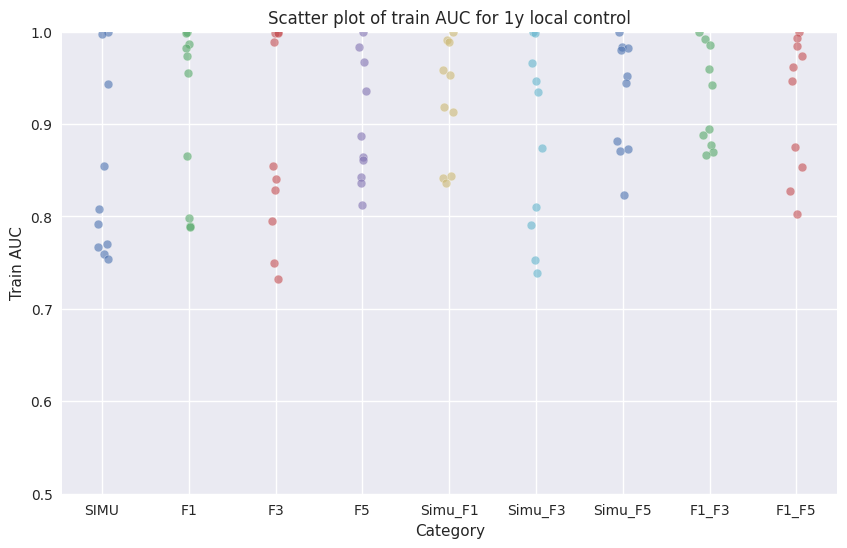

In [41]:
plt.figure(figsize=(10, 6))
data = analysis_functions.get_top_results_to_plot(top_results)

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of train AUC for 1y local control')
plt.ylim([0.5, 1])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Train AUC')
plt.show()


### Best test AUC
#### Display

In [42]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='test_auc', k = 10)
analysis_functions.print_top_results(top_results, metric='test_auc')

Table: simu_gtv.csv
  Mean test_auc: 0.635, Feature Selection Algorithm: RF, Prediction Algorithm: KNN, Features: ['original_gldm_DependenceNonUniformity', 'original_glrlm_GrayLevelNonUniformity', 'original_shape_Sphericity'], Parameters: {}
  Mean test_auc: 0.627, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity'], Parameters: {}
  Mean test_auc: 0.623, Feature Selection Algorithm: RF, Prediction Algorithm: RF, Features: ['original_gldm_DependenceNonUniformity', 'original_glrlm_GrayLevelNonUniformity', 'original_shape_Sphericity'], Parameters: {}

Table: f1_gtv.csv
  Mean test_auc: 0.662, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: KNN, Features: ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity'], Parameters: {}
  Mean test_auc: 0.625, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: QDA, Features: ['original_

#### Scatter plot

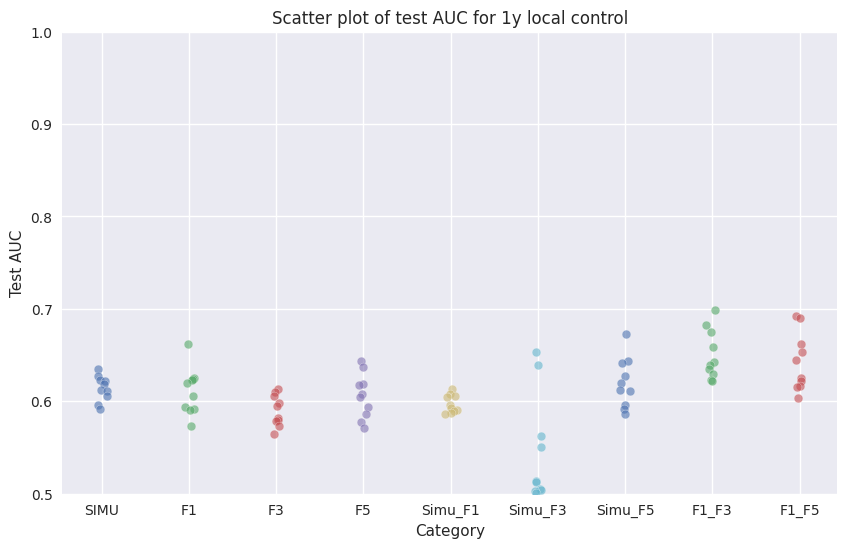

In [43]:
plt.figure(figsize=(10, 6))
data = analysis_functions.get_top_results_to_plot(top_results)

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of test AUC for 1y local control')
plt.ylim([0.5, 1])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Test AUC')
plt.show()


### Best test brier loss
#### Display

In [44]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='test_brier_loss', k = 10)
analysis_functions.print_top_results(top_results, metric='test_brier_loss')

Table: simu_gtv.csv
  Mean test_brier_loss: 0.238, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: RF, Features: ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity'], Parameters: {}
  Mean test_brier_loss: 0.239, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: PSVM, Features: ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity'], Parameters: {}
  Mean test_brier_loss: 0.24, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: PSVM, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}

Table: f1_gtv.csv
  Mean test_brier_loss: 0.228, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: KNN, Features: ['original_shape_Maximum2DDiameterRow', 'original_glrlm_GrayLevelNonUniformity'], Parameters: {}
  Mean test_brier_loss: 0.239, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: RF, Features: ['original_shape_Maximum2DDiameterRow', 'original_glrlm_Gray

#### Scatter plot

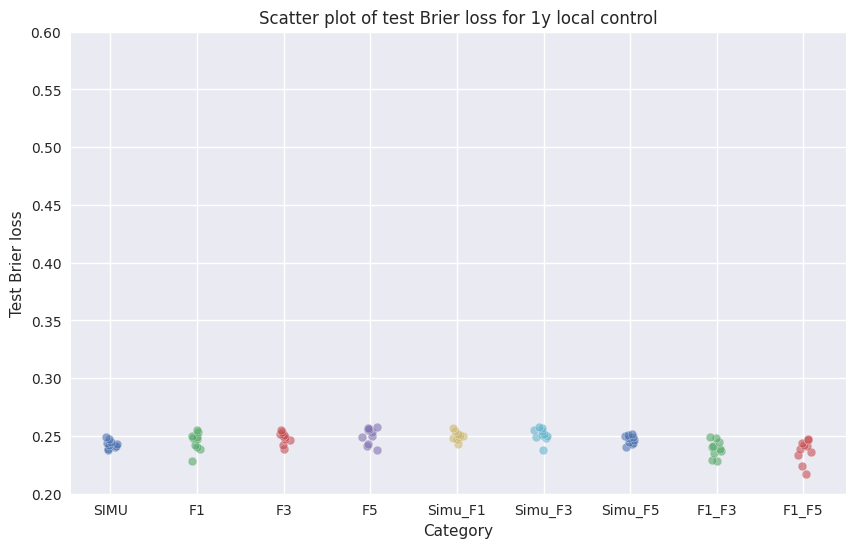

In [45]:
plt.figure(figsize=(10, 6))
data = analysis_functions.get_top_results_to_plot(top_results)

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of test Brier loss for 1y local control')
plt.ylim([0.2, 0.6])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Test Brier loss')
plt.show()


### Spe and Sens

In [46]:
analysis_functions.find_perf_alg(results, delta_rad_tables, [outcome], feat_sel_algo_list, pred_algo_list, metric='sens_spec', threshold=0.65)

Table: simu_f5_gtv.csv, Outcome: nine_months_metastatic_status, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Number of Features: 2, '
'                                           TEST AUC: 0.672522209778572, Sensitivity: 0.7333333333333331, Specificity: 0.6818181818181811, '
'                                           Features: ['original_glcm_JointEntropy', 'original_glcm_Id']
